In [1]:
using Plots; plt = Plots

In [2]:
#func(y, x) = sin.(2*π*x) .* cos.(2*π*y) .+ 0.1
#func(y, x) = sin.(2*π*(x-y)).+ 0.1

#σ = 0.1
#func(x, y) = exp.(-(x - 3/4)^2/σ^2 - (y - 1/4)^2/σ^2).+ 0.0

#τ = 0.5
#func(y, x) = exp.(-(1 - abs.(x - y))/τ).+ 0.0

#τ = 0.5
#func(y, x) = exp.(-(x - y)/τ) * (x > y)

τ = 0.2
#func(x, y) = exp.(-(1 - y)/τ) * (x >= y)
func(x, y) = exp.(-(1 - x)/τ - (x - y)/τ) * (x >= y)

func (generic function with 1 method)

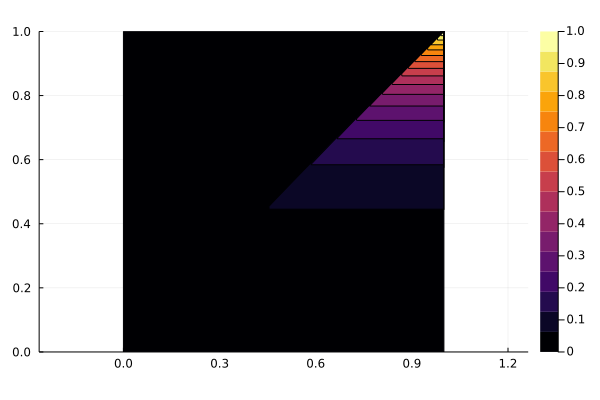

In [3]:
x = y = range(0, stop=1, length=100)
plt.plot(x, y, func, st=:contourf, aspect_ratio=:equal)

# Exact reference results

In [4]:
using MultiQuad: dblquad

In [5]:
#res_sq, error_sq = dblquad(
#    func, 0, 1, 0, 1, rtol=1e-12, atol=1e-12)

#println("error = $error_sq")
#println("res = $res_sq")

In [6]:
res_trid, error_trid = dblquad(
    (y, x) -> func(x, y), 0, 1, (x)->x, (x)->1, rtol=1e-12, atol=1e-12)

res_tri, error_tri = dblquad(
    #func, 0, 1, (x)->x, (x)->1, rtol=1e-12, atol=1e-12)
    (y, x) -> func(x, y), 0, 1, (x)->0, (x)->x, rtol=1e-12, atol=1e-12)

println("res_tri = $res_tri ± $error_tri")

res_sq = res_tri + res_trid
error_sq = error_tri + error_trid

println("res_sq  = $res_sq ± $error_sq")

ana_tri = τ * ( τ - (τ + 1)*exp(-1/τ) )
println("ana_tri = $ana_tri")

res_tri = 0.038382892720219636 ± 9.996218716159318e-13
res_sq  = 0.038382892720219636 ± 9.996218716159318e-13
ana_tri = 0.0383828927202195


# Quasi Monte Carlo integration

On the unit square

In [7]:
using Sobol; sb = Sobol

In [8]:
d = 2
N = 512
s = sb.SobolSeq(d)
Y = hcat([sb.next!(s) for i = 1:N]...)

2×512 Matrix{Float64}:
 0.5  0.75  0.25  0.375  0.875  0.625  …  0.501953    0.00195312  0.00292969
 0.5  0.25  0.75  0.375  0.875  0.125     0.00195312  0.501953    0.250977

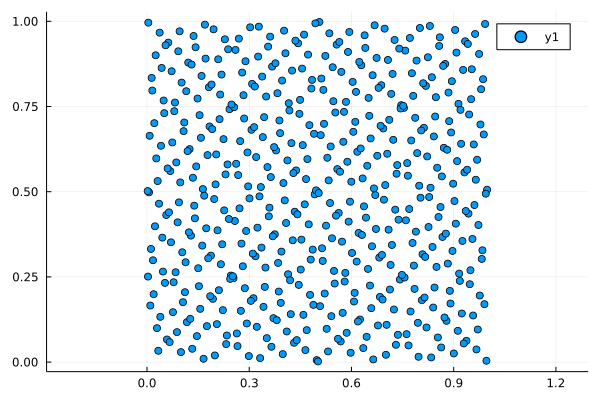

In [9]:
plt.plot(Y[1, :], Y[2, :], seriestype=:scatter, aspect_ratio=:equal)

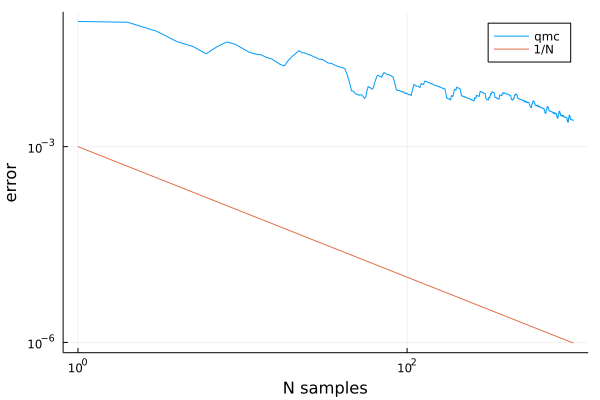

In [10]:
function sample_sq(N, seq)
    acc = 0.
    for n in 1:N
        v = sb.next!(seq)
        x, y = v[1], v[2]
        val = func(x, y)
        acc += val
    end
    res = acc / N
    return res
end

seq = sb.SobolSeq(2)

N = 1024
M = 1024

res = Array{Float64}(undef, M)
acc = 0.

for m in 1:M
    r = sample_sq(N, seq)
    acc += r
    res = vcat(res, )
    res[m] = acc / m
end

plt.plot(abs.((res .- res_sq)/res_sq), lab="qmc")

x = 0.001 ./ collect(1:M)
plt.plot!(x, lab="1/N")

plt.yaxis!("error", :log10)
plt.xaxis!("N samples", :log10)

# Quasi Monte Carlo

On the simplex

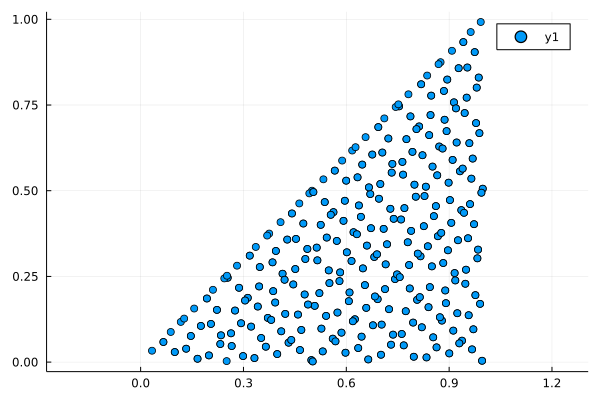

In [11]:
Yt = sort(Y, dims=1, rev=true)
plt.plot(Yt[1, :], Yt[2, :], seriestype=:scatter, aspect_ratio=:equal)

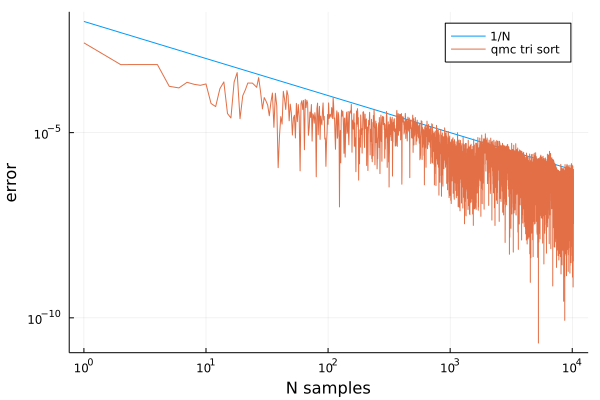

In [39]:
function sample_tri(N::Integer, seq::sb.SobolSeq)
    acc::Float64 = 0.
    for n in 1:N
        v = sb.next!(seq)
        v = sort(v)
        x, y = v[2], v[1]
        val = func(x, y)
        acc += val
    end
    jac = 0.5 # Jacobian of sort transform
    res = acc / N * jac
    return res
end

seq = sb.SobolSeq(2)

N = 1024
M = 1024 * 10

res_sort = Array{Float64}(undef, M)
acc = 0.

for m in 1:M
    r = sample_tri(N, seq)
    acc += r
    res = vcat(res, )
    res_sort[m] = acc / m
end

x = 0.01 ./ collect(1:M)
plt.plot(x, lab="1/N")
plt.plot!(abs.((res_sort .- res_tri)/res_tri), lab="qmc tri sort")

plt.yaxis!("error", :log10)
plt.xaxis!("N samples", :log10)

# Standard exponential model function

$$ 
h(v) = e^{-v / \tau}
$$

$$
x(v) = 1 - e^{-v/\tau}
$$

$$
v = -\tau \log(1 - x)
$$

In [1]:
d = 2
N = 512
s = sb.SobolSeq(d)
x = hcat([sb.next!(s) for i = 1:N]...)

τ_QMC = τ + 0.00
v = -τ_QMC * log.(1 .- x)

v1 = v[1, :]
v2 = v[2, :]

u1 = 1 .- v1
u2 = u1 .- v2

pv = plt.plot(v1, v2, seriestype=:scatter, aspect_ratio=:equal, lab="v")
pu = plt.plot(u1, u2, seriestype=:scatter, aspect_ratio=:equal, lab="u")
plt.plot(pv, pu, layout=(1, 2))

LoadError: UndefVarError: sb not defined

τ = 0.2
τ_QMC = 0.2


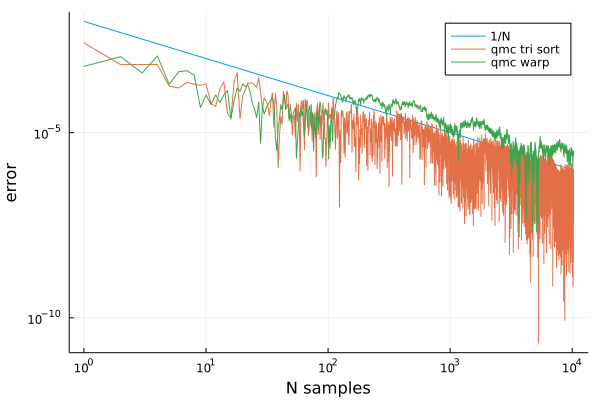

In [49]:

println("τ = $τ")
println("τ_QMC = $τ_QMC")

function sample_tri(N, seq, τ_QMC)
    acc = 0.
    for n in 1:N
        x = sb.next!(seq)

        v = -τ_QMC * log.(1 .- x)

        v1 = v[1]
        v2 = v[2]

        u1 = 1 .- v1
        u2 = u1 .- v2
        
        if u1 > 0 && u2 > 0
            val = func(u1, u2) / exp(-v1/τ_QMC) / exp(-v2/τ_QMC)
            acc += val
        end
    end
    jac = τ_QMC^2 # Jacobian of sort transform
    res = acc / N * jac
    return res
end

seq = sb.SobolSeq(2)

N = 1024
M = 1024 * 10

res = Array{Float64}(undef, M)
acc = 0.

for m in 1:M
    r = sample_tri(N, seq, τ_QMC)
    acc += r
    res = vcat(res, )
    res[m] = acc / m
end

res_warp = res

x = 0.01 ./ collect(1:M)
plt.plot(x, lab="1/N")
plt.plot!(abs.((res_sort .- res_tri)/res_tri), lab="qmc tri sort")
plt.plot!(abs.((res_warp .- res_tri)/res_tri), lab="qmc warp")

plt.yaxis!("error", :log10)
plt.xaxis!("N samples", :log10)

# Modified $v$ range

$$
h(v) = e^{-v / \tau}
$$

$$
x(v) 
= 
\frac{\int_0^v d\bar{v} h(v)}{\int_0^1 d\bar{v} h(v)}
= \frac{1 - e^{-v/\tau}}{1 - e^{-1/\tau}}
$$


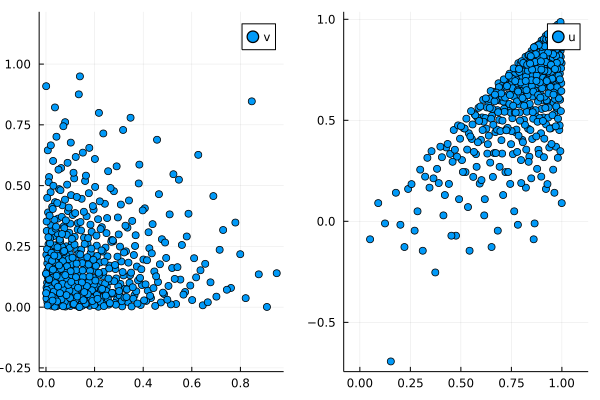

In [50]:
d = 2
N = 512
s = sb.SobolSeq(d)
x = hcat([sb.next!(s) for i = 1:N]...)

#τ = 0.5
τ_QMC = τ + 0.0
η_QMC = 1 - exp(-1/τ_QMC)
v = -τ_QMC * log.(1 .- η_QMC*x)

v1 = v[1, :]
v2 = v[2, :]

u1 = 1 .- v1 
u2 = u1 .- v2

pv = plt.plot(v1, v2, seriestype=:scatter, aspect_ratio=:equal, lab="v")
pu = plt.plot(u1, u2, seriestype=:scatter, aspect_ratio=:equal, lab="u")
plt.plot(pv, pu, layout=(1, 2))

τ = 0.2
τ_QMC = 0.2


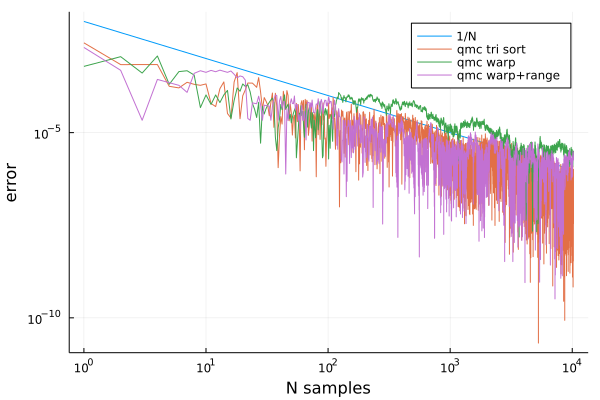

In [52]:

println("τ = $τ")
println("τ_QMC = $τ_QMC")

function sample_tri(N, seq, τ_QMC)
    acc = 0.
    η_QMC = 1 - exp(-1/τ_QMC)
    for n in 1:N
        x = sb.next!(seq)

        v = -τ_QMC * log.(1 .- η_QMC * x)

        v1 = v[1]
        v2 = v[2]

        u1 = 1 .- v1
        u2 = u1 .- v2
        
        if u1 > 0 && u2 > 0
            val = func(u1, u2) / exp(-v1/τ_QMC) / exp(-v2/τ_QMC)
            acc += val
        end
    end
    jac = τ_QMC^2 * η_QMC^2 # Jacobian of sort transform
    res = acc / N * jac
    return res
end

seq = sb.SobolSeq(2)

N = 1024
M = 1024 * 10

res = Array{Float64}(undef, M)
acc = 0.

for m in 1:M
    r = sample_tri(N, seq, τ_QMC)
    acc += r
    res = vcat(res, )
    res[m] = acc / m
end

res_warp_range = res

x = 0.01 ./ collect(1:M)
plt.plot(x, lab="1/N")
plt.plot!(abs.((res_sort .- res_tri)/res_tri), lab="qmc tri sort")
plt.plot!(abs.((res_warp .- res_tri)/res_tri), lab="qmc warp")
plt.plot!(abs.((res_warp_range .- res_tri)/res_tri), lab="qmc warp+range")

plt.yaxis!("error", :log10)
plt.xaxis!("N samples", :log10)

# Modified $v$ range with sort transform

$$
h(v) = e^{-v / \tau}
$$

$$
x(v) 
= 
\frac{\int_0^v d\bar{v} h(v)}{\int_0^1 d\bar{v} h(v)}
= \frac{1 - e^{-v/\tau}}{1 - e^{-1/\tau}}
$$


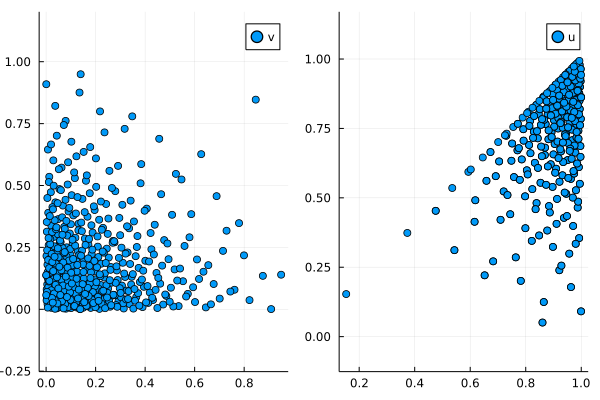

In [53]:
d = 2
N = 512
s = sb.SobolSeq(d)
x = hcat([sb.next!(s) for i = 1:N]...)

τ_QMC = τ + 0.0
η_QMC = 1 - exp(-1/τ_QMC)
v = -τ_QMC * log.(1 .- η_QMC*x)

v1 = v[1, :]
v2 = v[2, :]

u = sort(v, dims=1, rev=false)
u1 = 1 .- u[1, :] 
u2 = 1 .- u[2, :]

pv = plt.plot(v1, v2, seriestype=:scatter, aspect_ratio=:equal, lab="v")
pu = plt.plot(u1, u2, seriestype=:scatter, aspect_ratio=:equal, lab="u")
plt.plot(pv, pu, layout=(1, 2))

τ = 0.2
τ_QMC = 0.2


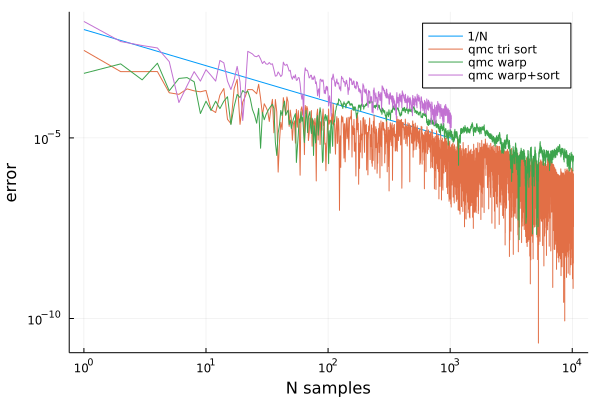

In [54]:

println("τ = $τ")
println("τ_QMC = $τ_QMC")

function sample_tri(N, seq, τ_QMC)
    acc = 0.
    η_QMC = 1 - exp(-1/τ_QMC)
    for n in 1:N
        x = sb.next!(seq)

        v = -τ_QMC * log.(1 .- η_QMC * x)

        v1 = v[1]
        v2 = v[2]

        u = sort(v)
        u1 = 1 .- u[1]
        u2 = 1 .- u[2]        
        
        if u1 > 0 && u2 > 0
            val = func(u1, u2) / exp(-v1/τ_QMC) / exp(-v2/τ_QMC)
            acc += val
        end
    end
    jac = 0.5 * τ_QMC^2 * η_QMC^2 # Jacobian of sort transform
    res = acc / N * jac
    return res
end

seq = sb.SobolSeq(2)

N = 1024
M = 1024

res = Array{Float64}(undef, M)
acc = 0.

for m in 1:M
    r = sample_tri(N, seq, τ_QMC)
    acc += r
    res = vcat(res, )
    res[m] = acc / m
end

res_sort_warp = res

x = 0.01 ./ collect(1:M)
plt.plot(x, lab="1/N")
plt.plot!(abs.((res_sort .- res_tri)/res_tri), lab="qmc tri sort")
plt.plot!(abs.((res_warp .- res_tri)/res_tri), lab="qmc warp")
plt.plot!(abs.((res_sort_warp .- res_tri)/res_tri), lab="qmc warp+sort")

plt.yaxis!("error", :log10)
plt.xaxis!("N samples", :log10)

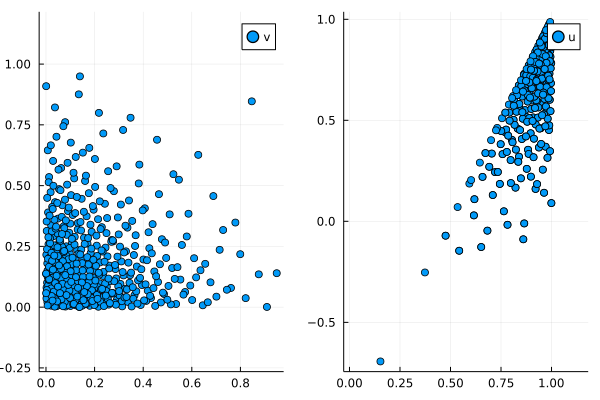

In [56]:
d = 2
N = 512
s = sb.SobolSeq(d)
x = hcat([sb.next!(s) for i = 1:N]...)

τ_QMC = τ + 0.0
η_QMC = 1 - exp(-1/τ_QMC)

x1 = x[1, :]
x2 = x[2, :]

v = -τ_QMC * log.(1 .- η_QMC*x)

v1 = v[1, :]
v2 = v[2, :]

V = sort(v, dims=1, rev=false)
#V = v

y1 = V[1, :]
y2 = V[2, :]

u1 = 1 .- y1
u2 = u1 .- y2

pv = plt.plot(v1, v2, seriestype=:scatter, aspect_ratio=:equal, lab="v")
pu = plt.plot(u1, u2, seriestype=:scatter, aspect_ratio=:equal, lab="u")
plt.plot(pv, pu, layout=(1, 2))

# Exact warping on triangle

$$
f(u_1, u_2) = p(u_1, u_2) = e^{-(1-u_2)/\tau} = p(u_1) p(u_2)
$$

Note that since products of exponential functions, factorize the modelfunction
$$
p_n(\mathbf{u}) = \prod_{i=1} h^{(i)}(u_{i-1} - u_i)
$$
with $h^{(i)}(v) = h(v) = e^{-v/\tau}$, can also be written as
$$
p_n(\mathbf{u}) = \prod_{i=1} h^{(i)}(u_{i-1} - u_i) = e^{-(u_0 - u_n)/\tau}
$$

Integrating over the triangle $1 \ge u_1 \ge u_2 \ge 0$ gives the normalization
$$
N 
= \int_0^1 d\bar{u}_2 \int_{\bar{u}_2}^1 d\bar{u}_1 \, p(\bar{u}_1, \bar{u}_2) 
= \tau^2 - \tau (\tau + 1)e^{-1/\tau}
$$



In [ ]:

[G1(u0 - u1)G2(u1 - u2)G2(u2 - u3)G2(u3 - u4)G2(u4 - 0)] Δ1(u1 - u3)Δ2(u2 - u4) = \prod h_{T_i}(u_i)

G_i(v) ≈ e^{-v/τ_i}
Δ_i(v) ≈ e^{-v/τ_{Δ_i}}
#Δ_i(v) ≈ e^{-v/τ_{0,Δ_i}} + e^{-v/τ_{β,Δ_i}}


In [57]:
N = τ * ( τ - (τ + 1)*exp(-1/τ) )
println("N = $N")

N = 0.0383828927202195


Jacobian

$$
\left| \frac{\partial \mathbf{u}}{\partial \mathbf{x}} \right|
= \frac{N}{p(\mathbf{u})}
= \tau \frac{\tau - (\tau + 1)e^{-1/\tau}}{e^{-(1-u_2)/\tau}}
$$

## Probability relations
$$
x_2(u_2) 
= \frac{1}{N} \int_0^{u_2} d\bar{u}_2 \int_{\bar{u}_2}^1 d\bar{u}_1 p(\bar{u}_1, \bar{u}_2) 
= \frac{(\tau + 1 - u_2 ) e^{-(1 - u_2)/\tau} - (\tau+1)e^{-1/\tau}}{\tau - (\tau+1)e^{-1/\tau}}
$$

$$
x_1(u_1, u_2) =
\frac{
\int_{u_2}^{u_1} d\bar{u}_1 p(\bar{u}_1, u_2)
}{
\int_{u_2}^1 d\bar{u}_1 p(\bar{u}_1, u_2)
}
= \frac{u_1 - u_2}{1 - u_2}
$$

Solving for $u_2$ given $x_2$ is non trivial.

In [58]:
using NonlinearSolve; nls = NonlinearSolve

function get_solvers(τ)

    η = (τ + 1)*exp(-1/τ)

    jac = τ*(τ - η)
    
    px2 = u2 -> @. ((τ + 1 - u2)*exp(-(1-u2)/τ) - η)/(τ - η)
    
    function solve_u2(x2)
        f(u,p) = px2(u) - x2
        bracket = (0., 1.)
        prob = nls.NonlinearProblem(f, bracket)
        #sol = nls.solve(prob, nls.Falsi(), tol=1e-3)
        sol = nls.solve(prob, nls.Bisection(), tol=1e-18)
        sol.u
    end

    function solve_u1(x1, u2)
        u2 + (1 - u2)*x1
    end
    
    solve_u2, solve_u1, px2, jac
end

get_solvers (generic function with 1 method)

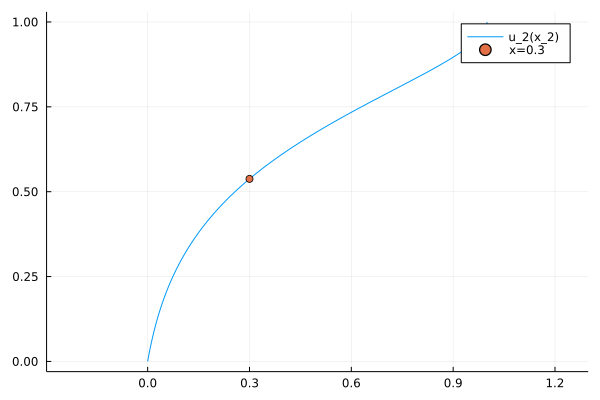

In [59]:
solve_u2, solve_u1, px2, jac = get_solvers(τ)

x2 = 0.3
u2_sol = solve_u2(x2)

u2 = collect(range(0, stop=1, length=100))
plt.plot(px2(u2), u2, aspect_ratio=:equal, lab="u_2(x_2)")
plt.plot!([x2], [u2_sol], seriestype=:scatter, lab="x=0.3")

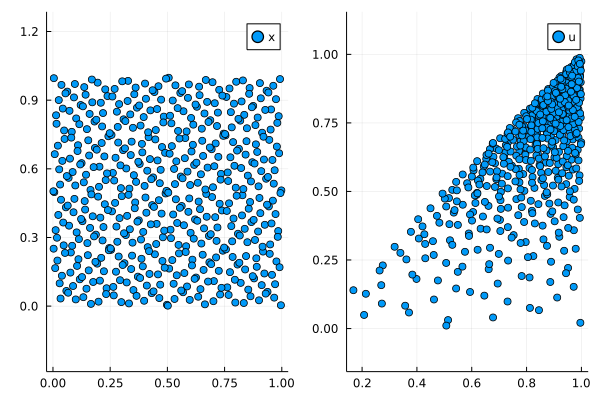

In [66]:
d = 2
N = 512
s = sb.SobolSeq(d)
x = hcat([sb.next!(s) for i = 1:N]...)

x1 = x[1, :]
x2 = x[2, :]

τ_QMC = τ + 0.001
solve_u2, solve_u1, px2, jac = get_solvers(τ_QMC)

u2 = [ solve_u2(x2_i) for x2_i in x2 ]
u1 = [ solve_u1(x1_i, u2_i) for (x1_i, u2_i) in zip(x1, u2) ]

pv = plt.plot(x1, x2, seriestype=:scatter, aspect_ratio=:equal, lab="x")
pu = plt.plot(u1, u2, seriestype=:scatter, aspect_ratio=:equal, lab="u")
plt.plot(pv, pu, layout=(1, 2))

τ = 0.2
τ_QMC = 0.201
0.0383828930513945
0.038382892720219636


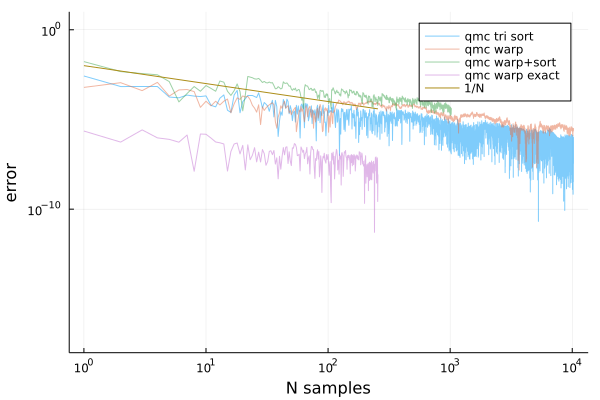

In [67]:

solve_u2, solve_u1, px2, C = get_solvers(τ_QMC)

println("τ = $τ")
println("τ_QMC = $τ_QMC")

function sample_tri(N, seq, τ_QMC)
    acc = 0.
    for n in 1:N
        x = sb.next!(seq)

        x1 = x[1]
        x2 = x[2]

        u2 = solve_u2(x2)
        u1 = solve_u1(x1, u2)
        
        val = func(u1, u2) / exp(-(1-u2)/τ_QMC)
        acc += val
        
        #if u1 >= 0 && u2 >= 0 && u1 >= u2
        #    val = func(u1, u2) / exp(-(1-u2)/τ_QMC)
        #    acc += val
        #end
    end
    #jac = N # Jacobian of sort transform
    res = (C / N) * acc
    return res
end

seq = sb.SobolSeq(2)

N = 1024
M = 256

res = Array{Float64}(undef, M)
acc = 0.

for m in 1:M
    r = sample_tri(N, seq, τ_QMC)
    acc += r
    res[m] = acc / m
end

println(res[end])
println(res_tri)

res_exact_warp = res

opt = Dict(:alpha=>0.5)

plt.plot(abs.((res_sort .- res_tri)/res_tri); lab="qmc tri sort", opt...)
plt.plot!(abs.((res_warp .- res_tri)/res_tri); lab="qmc warp", opt...)
plt.plot!(abs.((res_sort_warp .- res_tri)/res_tri); lab="qmc warp+sort", opt...)
plt.plot!(abs.((res_exact_warp .- res_tri)/res_tri); lab="qmc warp exact", opt...)
x = 0.01 ./ collect(1:M)
plt.plot!(x, lab="1/N")

plt.yaxis!("error", :log10)
plt.xaxis!("N samples", :log10)
plt.ylims!(1e-18, 1e1)